# Imports

In [ ]:
import numpy as np
from scipy.stats import kurtosis, entropy
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import os 
import seaborn as sns
import mne 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import antropy as ant
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Carga de datos

In [14]:
base_path = 'Data/NBack/'
print(os.listdir(base_path))

['EEG_1.csv', 'EEG_10.csv', 'EEG_11.csv', 'EEG_12.csv', 'EEG_13.csv', 'EEG_14.csv', 'EEG_15.csv', 'EEG_16.csv', 'EEG_17.csv', 'EEG_18.csv', 'EEG_19.csv', 'EEG_2.csv', 'EEG_3.csv', 'EEG_4.csv', 'EEG_5.csv', 'EEG_6.csv', 'EEG_7.csv', 'EEG_8.csv', 'EEG_9.csv', 'NBack_1.csv', 'NBack_10.csv', 'NBack_11.csv', 'NBack_12.csv', 'NBack_13.csv', 'NBack_14.csv', 'NBack_15.csv', 'NBack_16.csv', 'NBack_17.csv', 'NBack_18.csv', 'NBack_19.csv', 'NBack_2.csv', 'NBack_3.csv', 'NBack_4.csv', 'NBack_5.csv', 'NBack_6.csv', 'NBack_7.csv', 'NBack_8.csv', 'NBack_9.csv']


In [16]:
base_path = 'Data/NBack/'
channels_path = 'Data/'
# Leer nombres de canales
channels_file = os.path.join(channels_path, 'channels.csv')
channels = ['timestamp'] + pd.read_csv(channels_file, header=None).iloc[0].tolist()

# Inicializar listas
all_eeg = []
all_nback = []

# Obtener todos los archivos en el directorio
for filename in os.listdir(base_path):
    if filename.startswith('EEG_') and filename.endswith('.csv'):
        # Leer y arreglar coma inicial
        with open(os.path.join(base_path, filename), 'r') as f:
            lines = f.readlines()
        lines[0] = lines[0].lstrip(',')  # quitar coma inicial
        eeg_df = pd.read_csv(StringIO(''.join(lines)))
        eeg_df.columns = channels
        subject_id = filename.split('_')[1].split('.')[0]
        eeg_df['source_file'] = filename
        eeg_df['subject'] = subject_id
        all_eeg.append(eeg_df)

    elif filename.startswith('NBack_') and filename.endswith('.csv'):
        nback_df = pd.read_csv(os.path.join(base_path, filename))
        subject_id = filename.split('_')[1].split('.')[0]
        nback_df['source_file'] = filename
        nback_df['subject'] = subject_id
        all_nback.append(nback_df)

# Combinar en DataFrames únicos
combined_eeg = pd.concat(all_eeg, ignore_index=True)
combined_nback = pd.concat(all_nback, ignore_index=True)

# Mostrar resumen
print("EEG combinado:")
print(combined_eeg.head(), "\n")

print("NBack combinado:")
print(combined_nback.head())

EEG combinado:
   timestamp           F4            Oz            Fz            F8  \
0   0.045299  2327.497887  14123.593249  19397.060884  15709.190157   
1   0.049206  2370.036155  14146.383345  19430.449044  15774.822714   
2   0.053112  2344.581333  14114.430973  19402.548515  15743.916764   
3   0.057018  2391.159277  14158.879570  19451.718178  15794.388370   
4   0.060925  2308.747466  14097.809899  19366.471294  15694.175219   

            Pz            F5            T5           T3            C4  \
0  3360.109478  17359.494877  23611.987567  9074.315427  19640.499994   
1  3389.786490  17380.532825  23620.748308  9078.987823  19665.455941   
2  3350.107631  17357.085673  23599.345330  9150.229688  19653.215238   
3  3394.349377  17409.504111  23619.896570  9195.578694  19687.540310   
4  3320.880823  17326.848947  23567.526802  8976.560151  19600.456104   

             C3            T4            P4            T6           Cz  \
0  25970.245391  19613.512043  18377.614741  

# Segmentación por ventanas deslizantes

In [ ]:
def safe_int(value):
    try:
        if pd.isna(value):
            return None
        return int(value)
    except:
        return None

def generar_ventanas_deslizantes_por_test(combined_eeg, combined_nback, window_size=2, step_size=1, fs=256):
    ventanas = []
    etiquetas = []
    sujetos = []
    timestamps = []

    sujetos_unicos = combined_eeg['subject'].unique()

    for sujeto in sujetos_unicos:
        eeg_sujeto = combined_eeg[combined_eeg['subject'] == sujeto].reset_index(drop=True)
        nback_sujeto = combined_nback[combined_nback['subject'] == sujeto].reset_index(drop=True)

        # Obtener todos los eventos inicio (1) y final (2)
        inicios = nback_sujeto[nback_sujeto['Event Code'] == 1]
        finales = nback_sujeto[nback_sujeto['Event Code'] == 2]

        # Comprobar que haya mismo número de inicios y finales
        if len(inicios) != len(finales):
            print(f"Advertencia: sujeto {sujeto} tiene diferente número de inicios y finales.")
            min_len = min(len(inicios), len(finales))
            inicios = inicios.iloc[:min_len]
            finales = finales.iloc[:min_len]

        for i, (inicio, final) in enumerate(zip(inicios.itertuples(), finales.itertuples())):
            n_valor = safe_int(inicio.Notes)
            if n_valor is None:
                print(f"Advertencia: sujeto {sujeto} prueba {i+1} tiene valor n inválido. Se usa etiqueta 'Desconocida'.")
                etiqueta = 'Desconocida'
            elif n_valor == 0:
                etiqueta = 'Baja'
            elif n_valor == 1:
                etiqueta = 'Media'
            else:
                etiqueta = 'Alta'

            # Filtrar EEG entre inicio y final (por timestamp)
            eeg_segmento = eeg_sujeto[(eeg_sujeto['timestamp'] >= inicio.Time) & (eeg_sujeto['timestamp'] <= final.Time)].reset_index(drop=True)
            if eeg_segmento.empty:
                print(f"Advertencia: sujeto {sujeto} prueba {i+1} no tiene datos EEG en el intervalo.")
                continue

            # Eliminar columnas no EEG
            cols_no_eeg = ['timestamp', 'source_file', 'subject']
            eeg_array = eeg_segmento.drop(columns=[c for c in cols_no_eeg if c in eeg_segmento.columns]).values
            timestamps_arr = eeg_segmento['timestamp'].values

            win_samples = int(window_size * fs)
            step_samples = int(step_size * fs)

            if len(eeg_array) < win_samples:
                print(f"Advertencia: sujeto {sujeto} prueba {i+1} tiene menos datos ({len(eeg_array)}) que tamaño de ventana ({win_samples}). Se omite.")
                continue

            for start in range(0, len(eeg_array) - win_samples + 1, step_samples):
                end = start + win_samples
                ventana = eeg_array[start:end, :]
                ventanas.append(ventana)
                etiquetas.append(etiqueta)
                sujetos.append(sujeto)
                timestamps.append(timestamps_arr[start])

    return ventanas, etiquetas, sujetos, timestamps

 #Ejemplo de uso:
ventanas, etiquetas, sujetos, tiempos = generar_ventanas_deslizantes_por_test(combined_eeg, combined_nback)
print(f"Total ventanas: {len(ventanas)}")
print(f"Forma de ventana ejemplo: {ventanas[0].shape}")
print(f"Etiqueta ejemplo: {etiquetas[0]}")

Ejemplo de etiqueta de una ventana: []


In [ ]:
ventanas = []
etiquetas = []

for archivo in combined_eeg['source_file'].unique():
    eeg_archivo = combined_eeg[combined_eeg['source_file'] == archivo].reset_index(drop=True)
    nback_archivo = combined_nback[combined_nback['source_file'] == archivo].reset_index(drop=True)
    for i in range(0, len(eeg_archivo) - ventana + 1, desplazamiento):
        ventana_df = eeg_archivo.iloc[i:i + ventana].copy()
        t_ini = ventana_df['timestamp'].iloc[0]
        t_fin = ventana_df['timestamp'].iloc[-1]
        # Filtrar eventos NBack en ese intervalo
        eventos_ventana = nback_archivo[(nback_archivo['Time'] >= t_ini) & (nback_archivo['Time'] <= t_fin)]
        # Ejemplo: etiqueta = lista de números presentados en la ventana
        numeros_presentados = eventos_ventana['Notes'].dropna().tolist()
        ventanas.append(ventana_df)
        etiquetas.append(numeros_presentados)  # O define aquí tu lógica de etiqueta

print("Ejemplo de etiqueta de una ventana:", etiquetas[0])

# Extracción de características

In [32]:
print("Etiquetas únicas:", set(etiquetas))
print("Cantidad total de etiquetas:", len(etiquetas))


Etiquetas únicas: {'Media', 'Alta'}
Cantidad total de etiquetas: 4298


In [40]:

def extraer_caracteristicas(ventanas, etiquetas, sujetos, fs=256):
    caracteristicas = []
    nombres_columnas = []

    # Suponemos que todas las ventanas tienen la misma forma
    n_canales = ventanas[0].shape[1]

    for i, ventana in enumerate(ventanas):
        carac_ventana = []

        for canal in range(n_canales):
            señal = ventana[:, canal]

            # Características estadísticas
            carac_ventana.append(np.mean(señal))          # Media
            carac_ventana.append(np.std(señal))           # Desviación estándar
            carac_ventana.append(np.min(señal))           # Mínimo
            carac_ventana.append(np.max(señal))           # Máximo
            carac_ventana.append(skew(señal))             # Asimetría
            carac_ventana.append(kurtosis(señal))         # Curtosis

            # Características espectrales usando Welch
            frecs, psd = welch(señal, fs=fs)

            # Bandas de frecuencia típicas (Hz)
            bandas = {
                'delta': (0.5, 4),
                'theta': (4, 8),
                'alpha': (8, 13),
                'beta':  (13, 30),
                'gamma': (30, 45)
            }

            for nombre_banda, (f_low, f_high) in bandas.items():
                idx_banda = np.logical_and(frecs >= f_low, frecs <= f_high)
                potencia_banda = np.mean(psd[idx_banda]) if np.any(idx_banda) else 0
                carac_ventana.append(potencia_banda)

        caracteristicas.append(carac_ventana)

    # Crear nombres de columnas
    for canal in range(n_canales):
        nombres_columnas += [
            f'ch{canal}_mean', f'ch{canal}_std', f'ch{canal}_min',
            f'ch{canal}_max', f'ch{canal}_skew', f'ch{canal}_kurt'
        ]
        for banda in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
            nombres_columnas.append(f'ch{canal}_{banda}_power')

    # Crear DataFrame y añadir etiquetas y sujetos
    df_carac = pd.DataFrame(caracteristicas, columns=nombres_columnas)
    df_carac['etiqueta'] = etiquetas
    df_carac['sujeto'] = sujetos

    return df_carac
df_caracteristicas = extraer_caracteristicas(ventanas, etiquetas, sujetos)
print(df_caracteristicas.head())


      ch0_mean    ch0_std      ch0_min      ch0_max  ch0_skew  ch0_kurt  \
0  2259.678995  16.379153  2215.798430  2332.304127  0.785506  2.738366   
1  2268.834996  18.877130  2215.798430  2349.046878  1.153198  2.954077   
2  2279.477382  16.451454  2232.297827  2349.046878  0.849144  2.428969   
3  2290.175045  20.826978  2253.457452  2387.776657  2.002390  5.132690   
4  2307.469026  20.982323  2259.334449  2387.776657  0.598732  0.764435   

   ch0_delta_power  ch0_theta_power  ch0_alpha_power  ch0_beta_power  ...  \
0        13.950712         2.208969         4.521039        0.972905  ...   
1        42.120196         7.307967         5.906018        1.474663  ...   
2        21.841650         5.396430         3.707361        1.241512  ...   
3        55.530696        22.394523         3.221333        0.891663  ...   
4        60.562939        24.744173         2.507977        1.015427  ...   

       ch15_max  ch15_skew  ch15_kurt  ch15_delta_power  ch15_theta_power  \
0  18912.

# Preprocesamiento

In [42]:

# Separar características y etiquetas
X = df_caracteristicas.drop(columns=['etiqueta', 'sujeto'])  # solo características
y = df_caracteristicas['etiqueta']                           # etiquetas (Baja, Media, Alta)

# Escalado estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos: entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Entrenamiento del modelo

## Random Forest

In [43]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

        Alta       1.00      1.00      1.00       573
       Media       1.00      1.00      1.00       287

    accuracy                           1.00       860
   macro avg       1.00      1.00      1.00       860
weighted avg       1.00      1.00      1.00       860



## SVM

In [44]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

        Alta       0.71      0.97      0.82       573
       Media       0.78      0.22      0.35       287

    accuracy                           0.72       860
   macro avg       0.75      0.60      0.58       860
weighted avg       0.74      0.72      0.66       860



## KNN

In [45]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Classification Report:
              precision    recall  f1-score   support

        Alta       0.83      0.88      0.85       573
       Media       0.73      0.63      0.67       287

    accuracy                           0.80       860
   macro avg       0.78      0.75      0.76       860
weighted avg       0.79      0.80      0.79       860



# Visualización

## Matiz de confusión

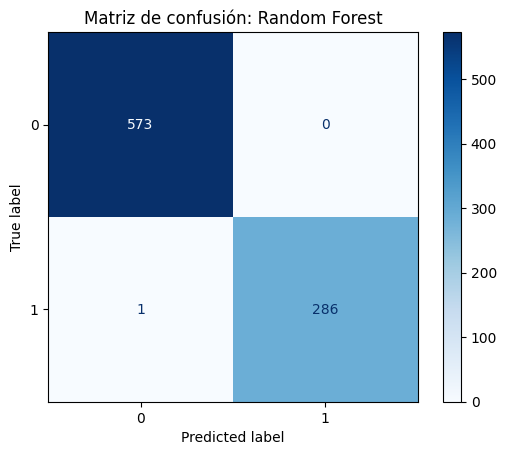

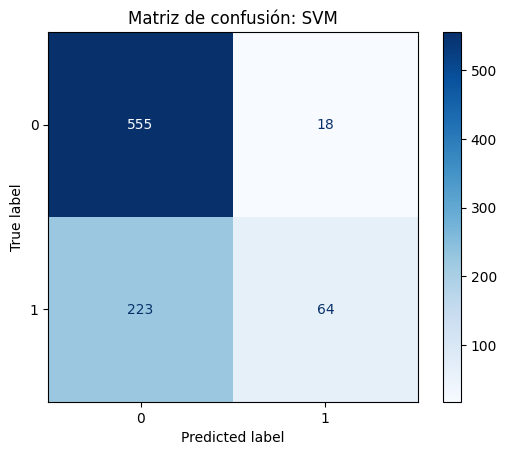

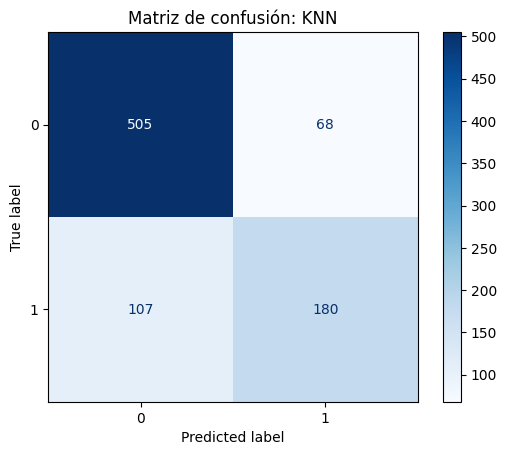

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de confusión: {model_name}')
    plt.grid(False)
    plt.show()

plot_confusion(y_test, y_pred_rf, "Random Forest")
plot_confusion(y_test, y_pred_svm, "SVM")
plot_confusion(y_test, y_pred_knn, "KNN")


## Métricas

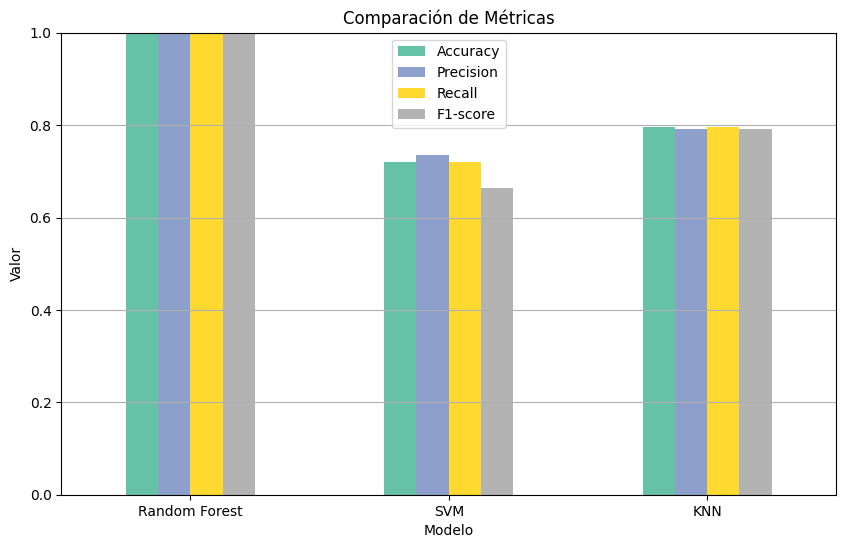

In [47]:


def get_metrics(y_true, y_pred, model_name):
    return {
        "Modelo": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-score": f1_score(y_true, y_pred, average='weighted')
    }

results = [
    get_metrics(y_test, y_pred_rf, "Random Forest"),
    get_metrics(y_test, y_pred_svm, "SVM"),
    get_metrics(y_test, y_pred_knn, "KNN")
]

metrics_df = pd.DataFrame(results)

# Visualización en barra
metrics_df.set_index("Modelo")[["Accuracy", "Precision", "Recall", "F1-score"]].plot(kind='bar', figsize=(10,6), ylim=(0,1), colormap="Set2")
plt.title("Comparación de Métricas")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


## Visualización 2D de los datos con PCA

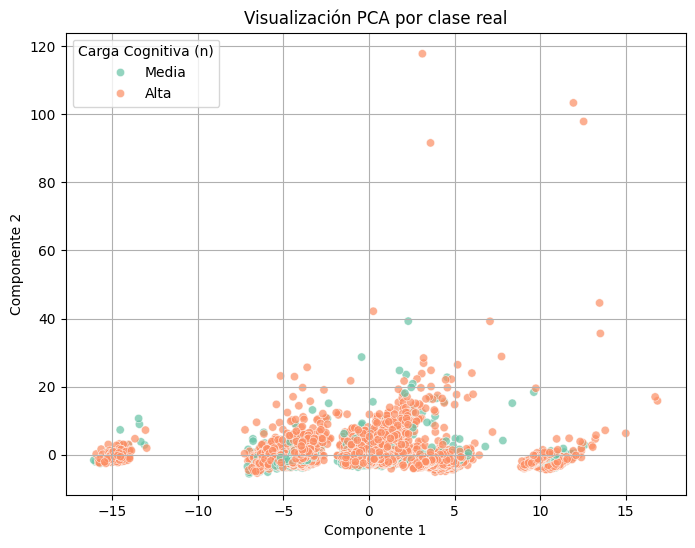

In [48]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización con clases reales
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set2', alpha=0.7)
plt.title("Visualización PCA por clase real")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Carga Cognitiva (n)")
plt.grid(True)
plt.show()